<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/350_normal_normal_model.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(distr-coniugate-2-notebook)=
# Distribuzioni coniugate (2)

In questo capitolo, esploreremo il modello normale-normale. Una caratteristica distintiva di questo modello risiede nella proprietà di auto-coniugazione della distribuzione gaussiana rispetto a una funzione di verosimiglianza anch'essa gaussiana. In altre parole, se la funzione di verosimiglianza segue una distribuzione gaussiana, scegliere una distribuzione a priori gaussiana per la media garantirà che anche la distribuzione a posteriori, a sua volta, rimanga gaussiana.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 12345
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

## Derivazione Analitica della Distribuzione a Posteriori nel Caso Normale con Varianza Nota

Supponiamo di avere un campione $ y = [Y_1, \ldots, Y_n] $ di $ n $ osservazioni indipendenti ed identicamente distribuite (iid) provenienti da una distribuzione normale $ \mathcal{N}(\mu, \sigma) $, dove $ \sigma $ è noto. Vogliamo effettuare inferenze sul parametro $ \mu $ e, per farlo, utilizziamo un approccio bayesiano con una distribuzione a priori normale per $ \mu $. Questo schema è noto come "coniugato normale-normale".

La funzione di verosimiglianza $ p(y \mid \mu, \sigma) $ per un campione iid è già nota come una distribuzione normale. Inoltre, la densità a priori $ p(\mu) $ è specificata come una distribuzione normale con media $ \mu_0 $ e varianza $ \sigma_0^2 $.

Il nostro obiettivo è derivare la distribuzione a posteriori $ p(\mu \mid y) $. In termini matematici, la densità congiunta delle osservazioni $ Y_1, \ldots, Y_n $ è data da:

$$
p(y \mid \mu) = \prod_{i=1}^n \frac{1}{{\sigma \sqrt {2\pi}}}\exp\left\{{-\frac{(y_i - \mu)^2}.{2\sigma^2}}\right\}.
$$

La densità a priori per $ \mu $ è:

$$
p(\mu) = \frac{1}{{\sigma_0 \sqrt {2\pi}}}\exp\left\{{-\frac{(\mu - \mu_0)^2}{2\sigma_0^2}}\right\}.
$$

Sfruttando queste distribuzioni, la distribuzione a posteriori per $ \mu $ è anch'essa una distribuzione normale:

$$
p(\mu \mid y) = \frac{1}{{\sigma_p \sqrt {2\pi}}}\exp\left\{{-\frac{(\mu - \mu_p)^2}{2\sigma_p^2}}\right\},
$$

dove la media a posteriori $ \mu_p $ e la varianza a posteriori $ \sigma_p^2 $ sono date da:

$$
\mu_p = \frac{\frac{1}{\sigma_0^2}\mu_0 + \frac{n}{\sigma^2}\bar{y}}{\frac {1}{\sigma_0^2} + \frac{n}{\sigma^2}}
$$

$$
\sigma_p^2 = \frac{1}{\frac {1}{\sigma_0^2}+ \frac{n}{\sigma^2}}.
$$

### Considerazioni Finali

- La media a posteriori $ \mu_p $ è una combinazione ponderata della media a priori $ \mu_0 $ e della media campionaria $ \bar{y} $. Il peso di $ \bar{y} $ aumenta con il numero di osservazioni $ n $ e con la riduzione dell'incertezza a priori $ \sigma_0^2 $.
  
- La varianza a posteriori $ \sigma_p^2 $ è sempre più piccola dell'incertezza a priori $ \sigma_0^2 $ e decresce all'aumentare del numero $ n $ di osservazioni.

Questo risultato mette in luce l'interazione tra la conoscenza a priori e i dati osservati nel contesto bayesiano. La media a posteriori rappresenta un compromesso tra la media a priori e la media campionaria, con pesi che variano in base alla dimensione del campione e all'incertezza associata alla conoscenza a priori. Questa analisi è estremamente utile per la comprensione del comportamento delle stime bayesiane, specialmente quando si confrontano con le stime di massima verosimiglianza.

## Un esempio concreto

Per esaminare un esempio pratico, consideriamo i 30 valori BDI-II dei soggetti clinici esaminati da {cite}`zetsche_2019future`.

In [3]:
y = np.array(
    [
        26.0,
        35.0,
        30,
        25,
        44,
        30,
        33,
        43,
        22,
        43,
        24,
        19,
        39,
        31,
        25,
        28,
        35,
        30,
        26,
        31,
        41,
        36,
        26,
        35,
        33,
        28,
        27,
        34,
        27,
        22,
    ]
)

In [4]:
y_bar = np.mean(y)
print(y_bar)

30.933333333333334


La varianza $\sigma^2$ della popolazione viene ipotizzata come identica alla varianza del campione:

In [5]:
sigma = np.std(y)
sigma

6.495810615739622

Per fare un esempio, imponiamo su $\mu$ una distribuzione a priori $\mathcal{N}(30, 5)$. In tali circostanze, la distribuzione a posteriori del parametro $\mu$ può essere determinata per via analitica e corrisponde ad una Normale di media definita dall'eq. {eq}`eq-post-norm-mup` e varianza definita dall'eq. {eq}`eq-post-norm-taup2`. La figura seguente mostra un grafico della distribuzione a priori, della verosimiglianza e della distribuzione a posteriori di $\mu$.

Iniziamo con la verosimiglianza.

In [6]:
def gaussian(y, m, s):
    l = np.prod(stats.norm.pdf(y, loc=m, scale=s))
    return l

In [7]:
x_axis = np.arange(18, 38, 0.01)
s = np.std(y)
like = [gaussian(y, val, s) for val in x_axis]
l = like / np.sum(like) * 100

Usando l'eq. {eq}`eq-post-norm-mup`, definiamo una funzione che ritorna la media della distribuzione a posteriori di $\mu$.

In [8]:
def mu_post(sigma_0, mu_0, sigma, ybar, n):
    return (1 / sigma_0**2 * mu_0 + n / sigma**2 * ybar) / (
        1 / sigma_0**2 + n / sigma**2
    )

Troviamo la media a posteriori.

In [9]:
mu_0 = 30  # media della distribuzione a priori per mu
sigma_0 = 5  # sd della distribuzione a priori per mu
sigma = np.std(y)  # sd del campione (assunta essere sigma)
ybar = np.mean(y)  # media del campione
n = len(y)

mu_post(sigma_0, mu_0, sigma, ybar, n)

30.883620206009738

Definiamo una funzione che ritorna la deviazione standard della distribuzione a posteriori di $\mu$.

In [10]:
def sigma_post(sigma_0, sigma, n):
    return np.sqrt(1 / (1 / sigma_0**2 + n / sigma**2))

Troviamo la deviazione standard a posteriori.

In [11]:
sigma = np.std(y)  # sd del campione (assunta essere sigma)
n = len(y)

sigma_post(sigma_0, sigma, n)

1.1539504429303373

Possiamo ora disegnare la distribuzione a posteriori per la media della popolazione, insieme alla distribuzione a priori e alla verosimiglianza.

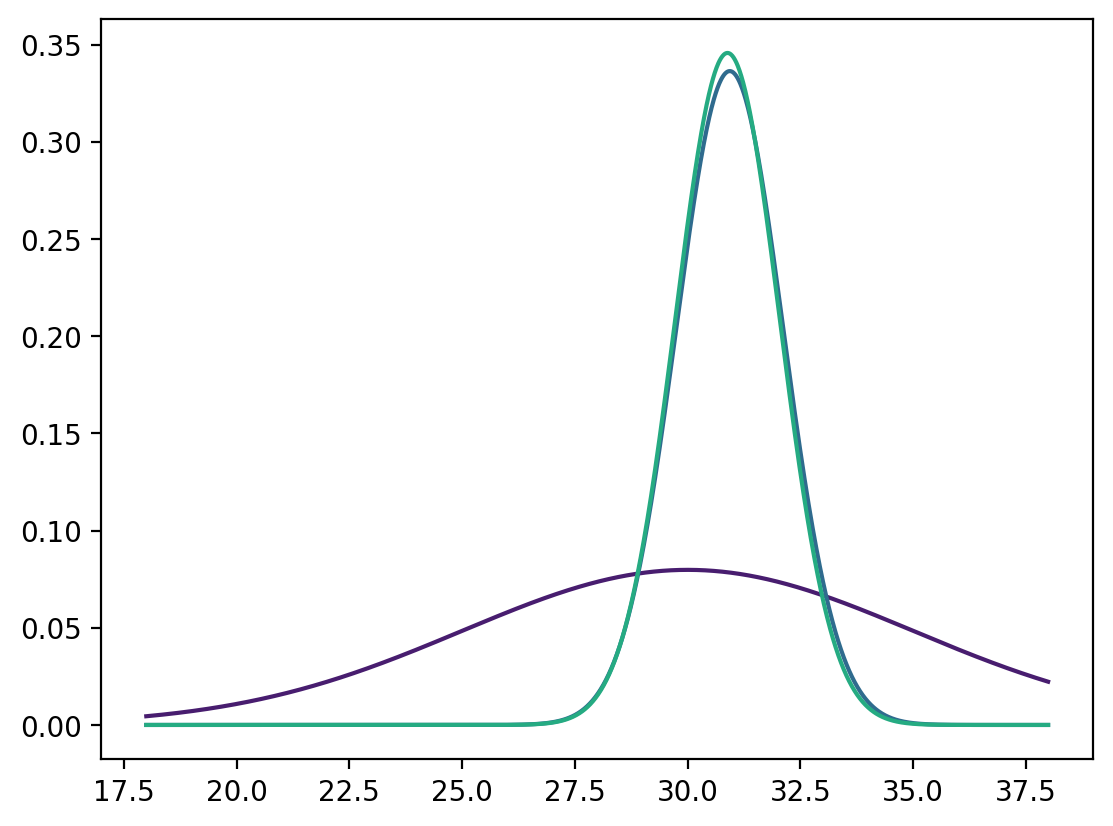

In [12]:
plt.plot(x_axis, stats.norm.pdf(x_axis, mu_0, sigma_0))
plt.plot(x_axis, l)
_ = plt.plot(
    x_axis,
    stats.norm.pdf(
        x_axis, mu_post(sigma_0, mu_0, sigma, ybar, n), sigma_post(sigma_0, sigma, n)
    ),
)

## Commenti e considerazioni finali

In questo capitolo, abbiamo affrontato l'aggiornamento bayesiano attraverso l'ottica del modello normale-normale. Questo modello è particolarmente elegante perché, se adottiamo una distribuzione normale come prior per il parametro di interesse, la distribuzione a posteriori che ne risulta è anch'essa una distribuzione normale.

Il processo ha inizio con una distribuzione a priori per il parametro $ \mu $, caratterizzata da una media $ \mu_0 $ e una varianza $ \sigma_0^2 $. A seguito dell'osservazione di nuovi dati, che assumiamo seguano una distribuzione normale con una media campionaria $ \bar{y} $ e una varianza nota $ \sigma^2 $, abbiamo applicato il teorema normale-normale per derivare la distribuzione a posteriori.

La media a posteriori, denotata come $ \mu_{\text{post}} $, emerge come una combinazione ponderata tra la media a priori $ \mu_0 $ e la media campionaria $ \bar{y} $. Questi pesi sono modulati dalle varianze $ \sigma_0^2 $ e $ \sigma^2 $ della distribuzione a priori e dei dati osservati, rispettivamente. Analogamente, la varianza a posteriori $ \sigma_{\text{post}}^2 $ è calcolata attraverso una formula che incorpora entrambe queste varianze.

In sintesi, questo capitolo ha evidenziato come l'uso del modello normale-normale in un contesto bayesiano faciliti notevolmente la computazione delle distribuzioni a posteriori. Questo è principalmente dovuto alla scelta di una distribuzione a priori normale, che mantiene la "coniugatezza" e quindi semplifica l'analisi.

## Watermark

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Nov 01 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.16.1

pytensor: 2.13.1

seaborn   : 0.13.0
scipy     : 1.11.3
arviz     : 0.16.1
numpy     : 1.25.2
matplotlib: 3.8.0
pandas    : 2.1.1

Watermark: 2.4.3

